In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
from  partie1 import GRUEncoder, GRUDecoder
from partie1 import LSTMEncoder, LSTMDecoder
from partie1 import TensorProductEncoder


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
##### entiers 0-10 
def generate_data(batch_size, seq_len, min_val=0, max_val=10):
    return torch.randint(min_val, max_val, (batch_size, seq_len))

def precision(predicted, target):
    correct = (predicted.argmax(dim=-1) == target).float()
    return correct.mean().item() * 100

# ENTRAINEMENT

## **GRU**

In [10]:

input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10

batch_size = 16
seq_len = 10
epochs = 100000
learning_rate = 0.001

encoder = GRUEncoder(input_size, emb_size, hidden_size)
decoder = GRUDecoder(emb_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss mieux adapté pour des classes discrètes
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

for epoch in range(epochs):
    x = generate_data(batch_size, seq_len)
    target = x.clone()

    hidden = encoder(x)
    reconstructed_x = decoder(hidden, seq_len)

    loss = criterion(reconstructed_x.view(-1, output_size), target.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = precision(reconstructed_x, target)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

print("Entraînement terminé")
torch.save(encoder.state_dict(), "./models/gru_enc.pth")
torch.save(decoder.state_dict(), "./models/gru_dec.pth")
print("Poids des modèles sauvegardés.")



Epoch [10/100000], Loss: 2.3061, Accuracy: 10.00%
Epoch [20/100000], Loss: 2.2942, Accuracy: 13.12%
Epoch [30/100000], Loss: 2.3026, Accuracy: 10.63%
Epoch [40/100000], Loss: 2.3108, Accuracy: 6.88%
Epoch [50/100000], Loss: 2.2936, Accuracy: 11.25%
Epoch [60/100000], Loss: 2.2997, Accuracy: 10.00%
Epoch [70/100000], Loss: 2.2971, Accuracy: 12.50%
Epoch [80/100000], Loss: 2.2956, Accuracy: 13.12%
Epoch [90/100000], Loss: 2.2876, Accuracy: 15.00%
Epoch [100/100000], Loss: 2.3020, Accuracy: 11.25%
Epoch [110/100000], Loss: 2.2713, Accuracy: 15.62%
Epoch [120/100000], Loss: 2.2598, Accuracy: 15.62%
Epoch [130/100000], Loss: 2.2702, Accuracy: 11.25%
Epoch [140/100000], Loss: 2.2649, Accuracy: 14.37%
Epoch [150/100000], Loss: 2.2495, Accuracy: 13.12%
Epoch [160/100000], Loss: 2.2388, Accuracy: 16.25%
Epoch [170/100000], Loss: 2.2324, Accuracy: 16.88%
Epoch [180/100000], Loss: 2.2056, Accuracy: 18.75%
Epoch [190/100000], Loss: 2.2622, Accuracy: 10.00%
Epoch [200/100000], Loss: 2.2363, Accurac

## **LSTM**

In [ ]:
input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10

batch_size = 16
seq_len = 10
epochs = 10000
learning_rate = 0.001

encoder = LSTMEncoder(input_size, emb_size, hidden_size)
decoder = LSTMDecoder(emb_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss mieux adapté pour des classes discrètes
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

for epoch in range(epochs):
    x = generate_data(batch_size, seq_len)
    target = x.clone()

    hidden = encoder(x)
    reconstructed_x = decoder(hidden, seq_len)

    loss = criterion(reconstructed_x.view(-1, output_size), target.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = precision(reconstructed_x, target)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

print("Entraînement terminé")
torch.save(encoder.state_dict(), "./models/lstm_enc.pth")
torch.save(decoder.state_dict(), "./models/lstm_dec.pth")
print("Poids des modèles sauvegardés.")

## **TPDN**


### GRU

In [3]:
def plot_tensors(tensor1, tensor2, labels=("Tensor 1", "Tensor 2")):

    tensor1 = tensor1.flatten()
    tensor2 = tensor2.flatten()
    x_indices = range(len(tensor1))


    plt.figure(figsize=(10, 6))
    plt.plot(x_indices, tensor1.detach().numpy(), label=labels[0], marker='o')
    plt.plot(x_indices, tensor2.detach().numpy(), label=labels[1], marker='x')

    plt.title("Comparaison des valeurs des tenseur en fonction de l'indice")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

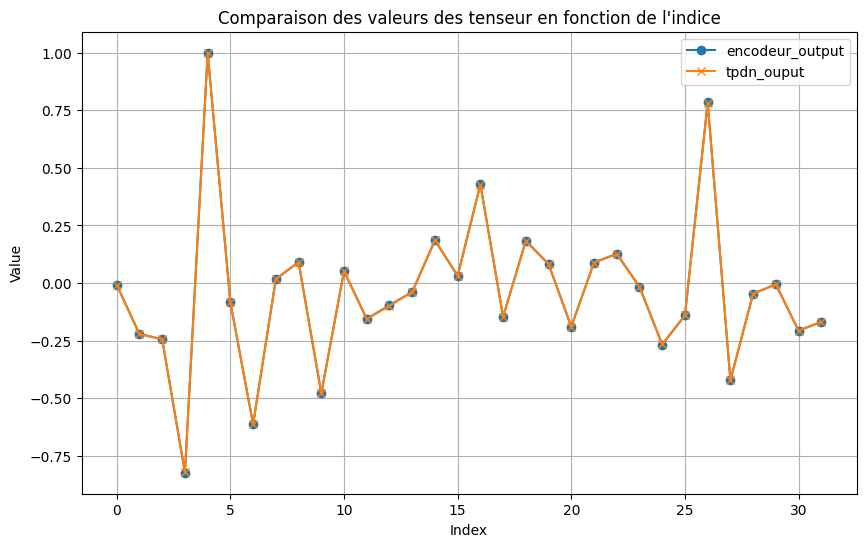

Epoch 29999/30000, Loss: 0.0000, Accuracy: 10.00%


In [5]:


input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10

batch_size = 1
seq_len = 10
epochs = 30000
learning_rate = 0.001
seq_len_tensor = torch.tensor([seq_len])

encoder = GRUEncoder(input_size, emb_size, hidden_size)
encoder.load_state_dict(torch.load("./models/gru_enc.pth"))

tpdnencoder = TensorProductEncoder(n_roles=seq_len, n_fillers=seq_len, filler_dim=hidden_size, role_dim=hidden_size, hidden_size=hidden_size)

decoder = GRUDecoder(emb_size, hidden_size, output_size)
decoder.load_state_dict(torch.load("./models/gru_dec.pth"))

def generate_data(batch_size, seq_len, input_size):
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # rôles
    return data, roles



criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(tpdnencoder.parameters()), lr=learning_rate)


for epoch in range(epochs):
    encoder.eval()
    tpdnencoder.train()

    data, roles = generate_data(batch_size, seq_len, input_size)

    encoder_output = encoder(data).squeeze(0)  
    tpdn_output = tpdnencoder(data, roles) 
    # reconstructed_x = decoder(tpdn_output.unsqueeze(0), seq_len_tensor)

    loss = criterion(encoder_output, tpdn_output.unsqueeze(0))

    # accuracy = precision(reconstructed_x, data)
    # print(accuracy)

    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



        # print( f"encodeur : {encoder_output}")

        # print( f"tpdn  : {tpdn_output}")
plot_tensors(encoder_output, tpdn_output, labels = ("encodeur_output","tpdn_ouput"))
print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

torch.save(tpdnencoder.state_dict(), "./models/tpdn_gru.pth")

### LSTM

In [3]:
input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10

batch_size = 16
seq_len = 10
epochs = 10000
learning_rate = 0.001

encoder = LSTMEncoder(input_size, emb_size, hidden_size)
encoder.load_state_dict(torch.load("./models/lstm_enc.pth"))

tpdnencoder = TensorProductEncoder(n_roles=seq_len, n_fillers=seq_len, filler_dim=hidden_size, role_dim=hidden_size, hidden_size=hidden_size)

def generate_data(batch_size, seq_len, input_size):
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # rôles
    return data, roles



criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(tpdnencoder.parameters()), lr=learning_rate)


for epoch in range(epochs):
    encoder.eval()
    tpdnencoder.train()

    data, roles = generate_data(batch_size, seq_len, input_size)

    encoder_output = encoder(data)[0].squeeze(0) # [0] pour avoir uniqument le hidden state et non le cell state

    tpdn_output = tpdnencoder(data, roles) 


    loss = criterion(encoder_output, tpdn_output)

    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

torch.save(tpdnencoder.state_dict(), "./models/tpdn_lstm.pth")

Epoch 0/10000, Loss: 4.1172
Epoch 100/10000, Loss: 0.0143
Epoch 200/10000, Loss: 0.0038
Epoch 300/10000, Loss: 0.0055
Epoch 400/10000, Loss: 0.0277
Epoch 500/10000, Loss: 0.0606
Epoch 600/10000, Loss: 0.1773
Epoch 700/10000, Loss: 0.0931
Epoch 800/10000, Loss: 0.0628
Epoch 900/10000, Loss: 0.0303
Epoch 1000/10000, Loss: 0.0295
Epoch 1100/10000, Loss: 0.0328
Epoch 1200/10000, Loss: 0.0136
Epoch 1300/10000, Loss: 0.0083
Epoch 1400/10000, Loss: 0.0437
Epoch 1500/10000, Loss: 0.0679
Epoch 1600/10000, Loss: 0.0321
Epoch 1700/10000, Loss: 0.0264
Epoch 1800/10000, Loss: 0.0177
Epoch 1900/10000, Loss: 0.0201
Epoch 2000/10000, Loss: 0.0084
Epoch 2100/10000, Loss: 0.0108
Epoch 2200/10000, Loss: 0.0271
Epoch 2300/10000, Loss: 0.0183
Epoch 2400/10000, Loss: 0.0143
Epoch 2500/10000, Loss: 0.0184
Epoch 2600/10000, Loss: 0.0177
Epoch 2700/10000, Loss: 0.0257
Epoch 2800/10000, Loss: 0.0232
Epoch 2900/10000, Loss: 0.0081
Epoch 3000/10000, Loss: 0.0061
Epoch 3100/10000, Loss: 0.0067
Epoch 3200/10000, Lo

# Eval / Test

Pour comprendre les différences d'accuracy en sortie du décodeur :

Step 1/tensor([10]): Output Distribution = tensor([[-13.1995,  -2.8855,  -2.6542, -12.0937, -14.9753, -10.4374, -15.5360,
         -20.2635,  -0.1360,  -7.0014]])
Step 2/tensor([10]): Output Distribution = tensor([[ -5.9251, -23.0347,  -7.0248, -13.5961,  -0.0918, -34.0933,  -2.4760,
         -12.8740, -16.3152, -10.2704]])
Step 3/tensor([10]): Output Distribution = tensor([[-1.7854e+01, -2.8930e+01, -3.0990e-04, -2.1980e+01, -1.2274e+01,
         -4.2567e+01, -8.1038e+00, -1.3577e+01, -1.3803e+01, -1.4447e+01]])
Step 4/tensor([10]): Output Distribution = tensor([[-1.7909e+01, -3.6299e+01, -1.3476e+01, -1.4984e+01, -1.4993e+01,
         -3.4016e+01, -1.2504e+01, -5.8412e-06, -2.8486e+01, -1.5925e+01]])
Step 5/tensor([10]): Output Distribution = tensor([[-2.7751e+01, -1.7960e+01, -7.4037e-04, -8.1368e+00, -6.1329e+01,
         -9.2476e+00, -6.4754e+01, -2.9990e+01, -9.8379e+00, -8.1193e+00]])
Step 6/tensor([10]): Output Distribution = tensor([[-9.2518e+00, -1.1195e+01, -1.3149e+01, -8.3

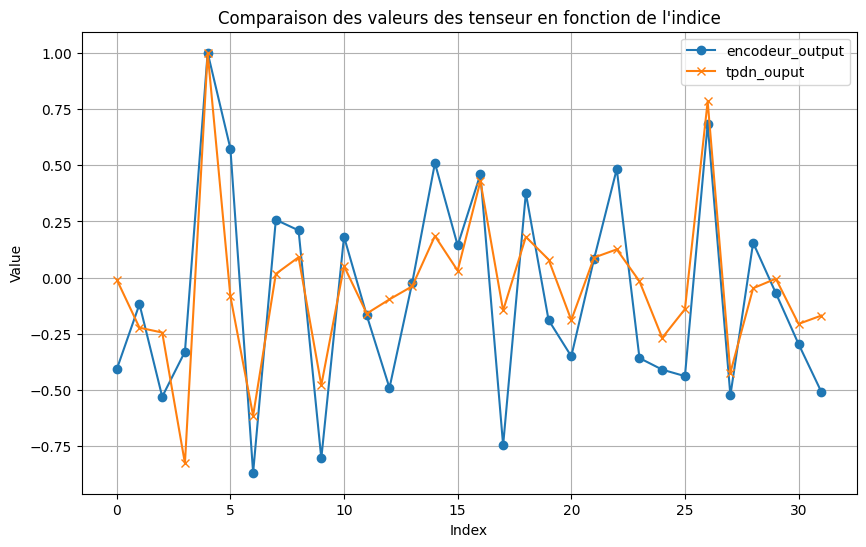

tensor([[0, 2, 6, 2, 8, 5, 0, 4, 2, 1]])
tensor([[8, 4, 2, 7, 2, 9, 9, 7, 7, 6]])
tensor([[0, 2, 6, 2, 8, 5, 0, 4, 2, 1]])
20.000000298023224


In [7]:


class GRUDecoder(nn.Module):
    def __init__(self, emb_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, hidden, output_len):
        """
        hidden : Dernier état caché de l'encodeur (1, batch_size, hidden_dim).
        """
        batch_size = hidden.size(1)
        outputs = []
        input_t = torch.zeros(batch_size, 1, self.hidden_size)  # Entrée initiale
        for step in range(output_len):
            output, hidden = self.rnn(input_t, hidden)
            output = self.out(output)  # (batch_size, 1, output_size)
            output = self.softmax(output)
            outputs.append(output.squeeze(1))  # (batch_size, output_size)
            print(f"Step {step + 1}/{output_len}: Output Distribution = {output.squeeze(1).detach()}")
        return torch.stack(outputs, dim=1)  # (batch_size, seq_len, output_size)


def generate_data(batch_size, seq_len, input_size):
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # rôles
    return data, roles




# Hyperparameters
input_size = 10
emb_size = 16
hidden_size = 32
output_size = 10
seq_len = 10
batch_size = 1 # Utiliser plusieurs exemples pour analyse

# Charger les modèles déjà entraînés
encoder = GRUEncoder(input_size, emb_size, hidden_size)
encoder.load_state_dict(torch.load("./models/gru_enc.pth"))

# tpdnencoder = TensorProductEncoder(n_roles=seq_len, n_fillers=seq_len, filler_dim=hidden_size, role_dim=hidden_size, hidden_size=hidden_size)
# tpdnencoder.load_state_dict(torch.load("./models/tpdn_gru.pth"))

decoder = GRUDecoder(emb_size, hidden_size, output_size)
decoder.load_state_dict(torch.load("./models/gru_dec.pth"))

encoder.eval()
tpdnencoder.eval()
decoder.eval()

### TEST
data, roles = generate_data(batch_size, seq_len, input_size)

encoder_outputs = encoder(data)  # (seq_len, batch_size, hidden_size)
tpdn_outputs = tpdnencoder(data, roles)  # (batch_size, hidden_size)

seq_len_tensor = torch.tensor([seq_len])

reconstructed_tpdn = decoder(tpdn_outputs.unsqueeze(0), seq_len_tensor)
reconstructed_gru = decoder(encoder_outputs, seq_len_tensor)

plot_tensors(encoder_outputs.squeeze(0)  , tpdn_outputs, labels = ("encodeur_output","tpdn_ouput"))
print(data)
print(reconstructed_tpdn.argmax(dim=-1))
print(reconstructed_gru.argmax(dim=-1))
print( precision(reconstructed_x, data))
